In [1]:
# !pip install autokeras


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

import logging
logging.getLogger('tensorflow').disabled = True

import autokeras as ak

import plotly.express as px
import copy 
import os
import json

from mylib import plot_roc, plot_pr_curve, plot_roc_train_test, plot_pr_train_test, hyper_table, predic_error_analysis, plot_pr_multi_class

## A Simple Example
The first step is to prepare your data. Here we use the [Titanic
dataset](https://www.kaggle.com/c/titanic) as an example.


In [3]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("eval.csv", TEST_DATA_URL)

First, let's try to visualize every feature of the training dataset, and color everything by the label.

survived     sex   age  n_siblings_spouses  parch     fare   class  \
0           0    male  22.0                   1      0   7.2500   Third   
1           1  female  38.0                   1      0  71.2833   First   
2           1  female  26.0                   0      0   7.9250   Third   
3           1  female  35.0                   1      0  53.1000   First   
4           0    male  28.0                   0      0   8.4583   Third   
..        ...     ...   ...                 ...    ...      ...     ...   
622         0    male  28.0                   0      0  10.5000  Second   
623         0    male  25.0                   0      0   7.0500   Third   
624         1  female  19.0                   0      0  30.0000   First   
625         0  female  28.0                   1      2  23.4500   Third   
626         0    male  32.0                   0      0   7.7500   Third   

        deck  embark_town alone  
0    unknown  Southampton     n  
1          C    Cherbourg     n  
2    unknown  Southampton     y  
3          C  Southampton     n  
4    unknown   Queenstown     y  
..       ...          ...   ...  
622  unknown  Southampton     y  
623  unknown  Southampton     y  
624        B  Southampton     y  
625  unknown  Southampton     n  
626  unknown   Queenstown     y  

[627 rows x 10 columns]

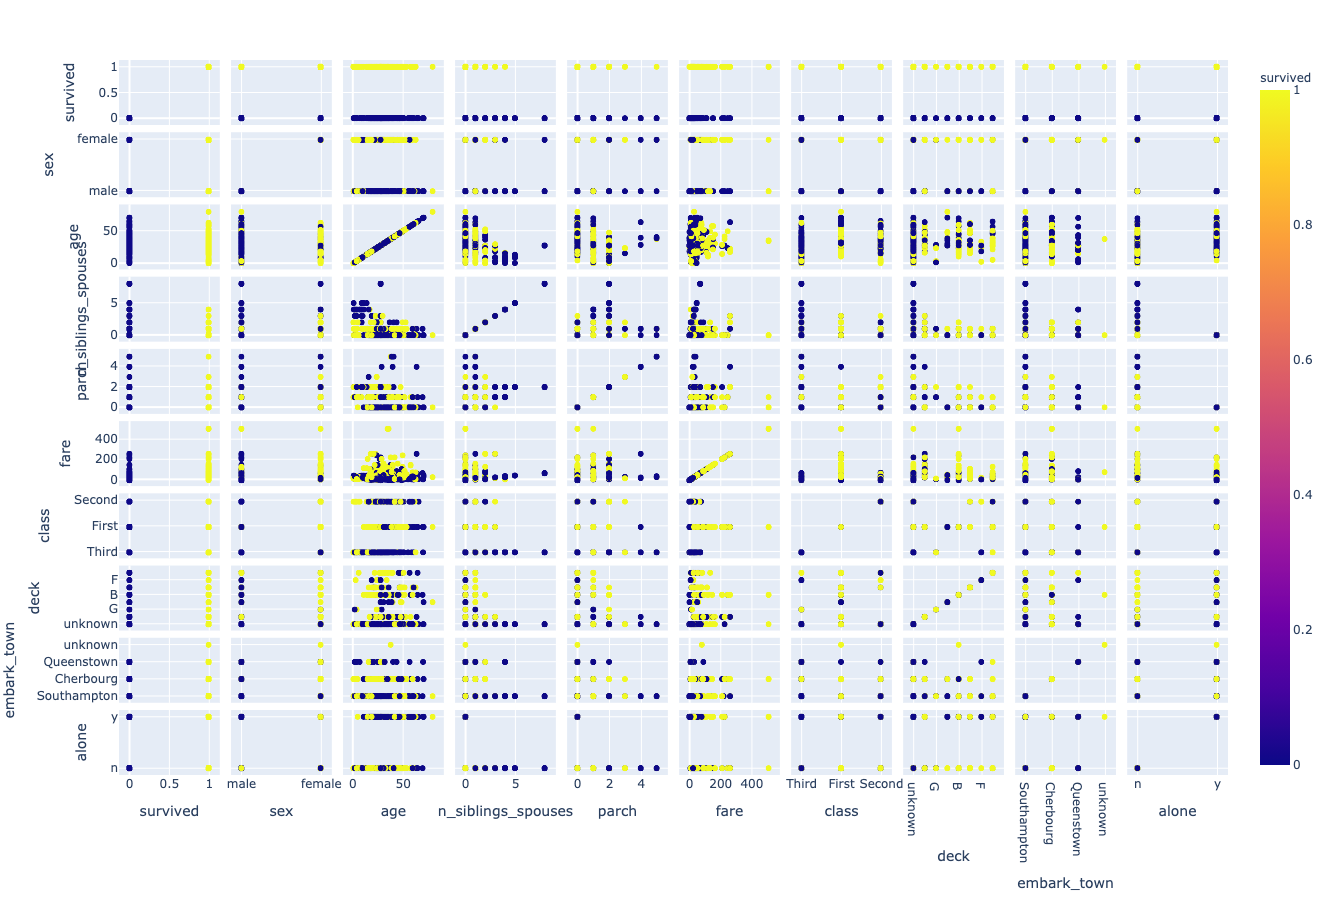

In [4]:
x_train = pd.read_csv(train_file_path)
df = copy.deepcopy(x_train)
y_train = x_train.pop("survived")

display(df)
features = ["survived", "sex",'age', 'n_siblings_spouses', 'parch','fare', 'class', 'deck', 'embark_town', 'alone']
fig = px.scatter_matrix(df, dimensions=features, color="survived")
fig.update_traces(diagonal_visible=True)
fig.update_layout(width=1200, height=900)
fig.show()

The second step is to run the
[StructuredDataClassifier](/structured_data_classifier).
As a quick demo, we set epochs to 10.
You can also leave the epochs unspecified for an adaptive number of epochs.


In [5]:
# Initialize the structured data classifier.
clf = ak.StructuredDataClassifier(
    overwrite=True, max_trials=3
)  # It tries 3 different models.
# Feed the structured data classifier with training data.
clf.fit(
    # The path to the train.csv file.
    train_file_path,
    # The name of the label column.
    "survived",
    epochs=10,
)
# Predict with the best model.
predicted_y = clf.predict(test_file_path)
# Evaluate the best model with testing data.
print(clf.evaluate(test_file_path, "survived"))

display(hyper_table())

Trial 3 Complete [00h 00m 02s]
val_accuracy: 0.8782608509063721

Best val_accuracy So Far: 0.886956512928009
Total elapsed time: 00h 00m 07s
Epoch 1/10
20/20 [==============================] - 0s 1ms/step - loss: 0.6858 - accuracy: 0.5150
Epoch 2/10
20/20 [==============================] - 0s 1ms/step - loss: 0.5920 - accuracy: 0.6907
Epoch 3/10
20/20 [==============================] - 0s 1ms/step - loss: 0.5388 - accuracy: 0.7568
Epoch 4/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4994 - accuracy: 0.8038
Epoch 5/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4694 - accuracy: 0.8220
Epoch 6/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4485 - accuracy: 0.8164
Epoch 7/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4350 - accuracy: 0.8172
Epoch 8/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4260 - accuracy: 0.8211
Epoch 9/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4

trial#1  trial#2  \
structured_data_block_1/normalize                       True     True   
structured_data_block_1/dense_block_1/num_layers           2        2   
structured_data_block_1/dense_block_1/use_batch...     False    False   
structured_data_block_1/dense_block_1/dropout              0        0   
structured_data_block_1/dense_block_1/units_0             32       32   
structured_data_block_1/dense_block_1/units_1             32       32   
classification_head_1/dropout                              0      0.5   
optimizer                                               adam     adam   
learning_rate                                          0.001    0.001   
score                                               0.886957  0.86087   

                                                     trial#3  
structured_data_block_1/normalize                       True  
structured_data_block_1/dense_block_1/num_layers           2  
structured_data_block_1/dense_block_1/use_batch...     False  
structured_data_block_1/dense_block_1/dropout              0  
structured_data_block_1/dense_block_1/units_0             32  
structured_data_block_1/dense_block_1/units_1            512  
classification_head_1/dropout                              0  
optimizer                                               adam  
learning_rate                                          0.001  
score                                               0.878261

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 9)                 0         
_________________________________________________________________
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense (Dense)                (None, 32)                320       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0     

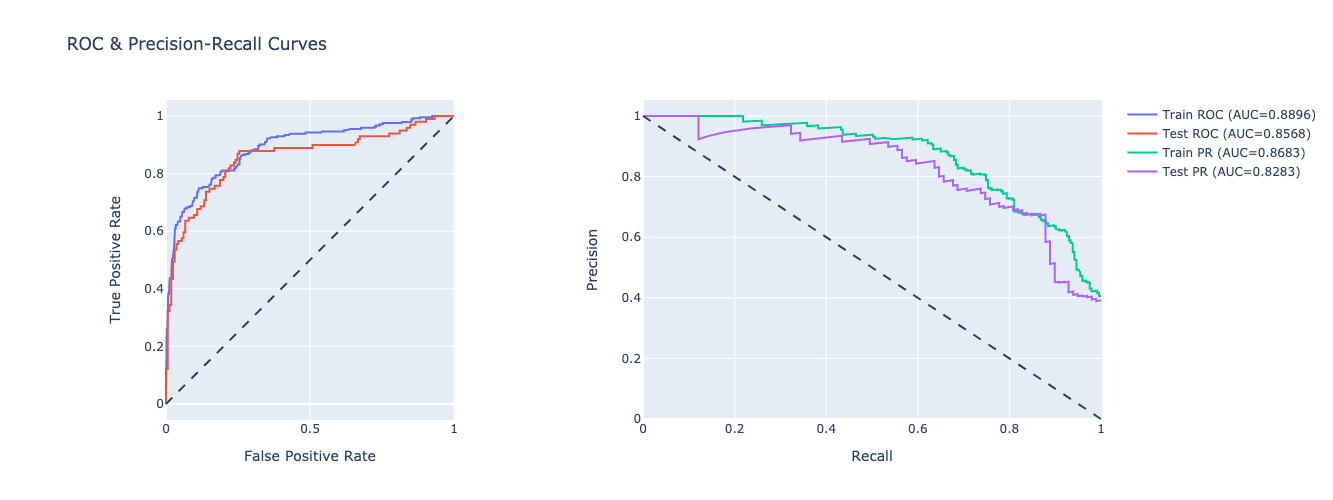

In [6]:
# Preparing testing data.
x_test = pd.read_csv(test_file_path)
y_test = x_test.pop("survived")

model = clf.export_model()
model.summary()

y_score = model.predict(x_test.astype(np.unicode))
y_score_train = model.predict(x_train.astype(np.unicode))

#plot_roc(y_test, y_score)
#plot_pr_curve(y_test, y_score)
#plot_roc_train_test(y_train, y_score_train, y_test, y_score)

plot_pr_train_test(y_train, y_score_train, y_test, y_score)

## Data Format
The AutoKeras StructuredDataClassifier is quite flexible for the data format.

The example above shows how to use the CSV files directly. Besides CSV files,
it also supports numpy.ndarray, pandas.DataFrame or [tf.data.Dataset](
https://www.tensorflow.org/api_docs/python/tf/data/Dataset?version=stable). The
data should be two-dimensional with numerical or categorical values.

For the classification labels,
AutoKeras accepts both plain labels, i.e. strings or integers, and one-hot encoded
encoded labels, i.e. vectors of 0s and 1s.
The labels can be numpy.ndarray, pandas.DataFrame, or pandas.Series.

The following examples show how the data can be prepared with numpy.ndarray,
pandas.DataFrame, and tensorflow.data.Dataset.


In [7]:
# x_train as pandas.DataFrame, y_train as pandas.Series
x_train = pd.read_csv(train_file_path)
print(type(x_train))  # pandas.DataFrame
y_train = x_train.pop("survived")
print(type(y_train))  # pandas.Series

# You can also use pandas.DataFrame for y_train.
y_train = pd.DataFrame(y_train)
print(type(y_train))  # pandas.DataFrame

# You can also use numpy.ndarray for x_train and y_train.
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
print(type(x_train))  # numpy.ndarray
print(type(y_train))  # numpy.ndarray

# Preparing testing data.
x_test = pd.read_csv(test_file_path)
y_test = x_test.pop("survived")

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [8]:
# It tries 10 different models.
clf = ak.StructuredDataClassifier(overwrite=True, max_trials=10)
# Feed the structured data classifier with training data.
clf.fit(x_train, y_train, epochs=10)
# Predict with the best model.
predicted_y = clf.predict(x_test)
# Evaluate the best model with testing data.
print(clf.evaluate(x_test, y_test))
display(hyper_table())

Trial 10 Complete [00h 00m 01s]
val_accuracy: 0.747826099395752

Best val_accuracy So Far: 0.895652174949646
Total elapsed time: 00h 00m 20s
Epoch 1/10
20/20 [==============================] - 0s 1ms/step - loss: 0.6604 - accuracy: 0.6045
Epoch 2/10
20/20 [==============================] - 0s 978us/step - loss: 0.5733 - accuracy: 0.7361
Epoch 3/10
20/20 [==============================] - 0s 963us/step - loss: 0.5151 - accuracy: 0.7648
Epoch 4/10
20/20 [==============================] - 0s 958us/step - loss: 0.4760 - accuracy: 0.8102
Epoch 5/10
20/20 [==============================] - 0s 954us/step - loss: 0.4510 - accuracy: 0.8254
Epoch 6/10
20/20 [==============================] - 0s 995us/step - loss: 0.4355 - accuracy: 0.8210
Epoch 7/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4262 - accuracy: 0.8211
Epoch 8/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4200 - accuracy: 0.8126
Epoch 9/10
20/20 [==============================] - 0s 1ms/step -

trial#1   trial#2  \
structured_data_block_1/normalize                      False      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         3   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
structured_data_block_1/dense_block_1/units_2             32        32   
score                                               0.747826  0.843478   

                                                     trial#3  trial#4  \
structured_data_block_1/normalize                       True     True   
structured_data_block_1/dense_block_1/use_batch...     False    False   
structured_data_block_1/dense_block_1/num_layers           2        2   
structured_data_block_1/dense_block_1/units_0             32       32   
structured_data_block_1/dense_block_1/dropout              0        0   
structured_data_block_1/dense_block_1/units_1             32       64   
classification_head_1/dropout                              0        0   
optimizer                                               adam     adam   
learning_rate                                          0.001    0.001   
structured_data_block_1/dense_block_1/units_2            NaN       16   
score                                               0.895652  0.86087   

                                                     trial#5   trial#6  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                            0.5      0.25   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
structured_data_block_1/dense_block_1/units_2            256       512   
score                                               0.878261  0.878261   

                                                     trial#7   trial#8  \
structured_data_block_1/normalize                       True     False   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
structured_data_block_1/dense_block_1/units_2             64       256   
score                                               0.878261  0.747826   

                                                     trial#9  trial#10  
structured_data_block_1/normalize                       True      True  
structured_data_block_1/dense_block_1/use_batch...     False     False  
structured_data_block_1/dense_block_1/num_layers           2         2  
structured_data_block_1/dense_block_1/units_0             32        32  
structured_data_block_1/dense_block_1/dropout              0         0  
structured_data_block_1/dense_block_1/units_1             32        32 

9/9 [==============================] - 0s 915us/step - loss: 0.4330 - accuracy: 0.7955
[0.43298786878585815, 0.7954545617103577]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 9)                 0         
_________________________________________________________________
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense (Dense)                (None, 32)                320       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056     

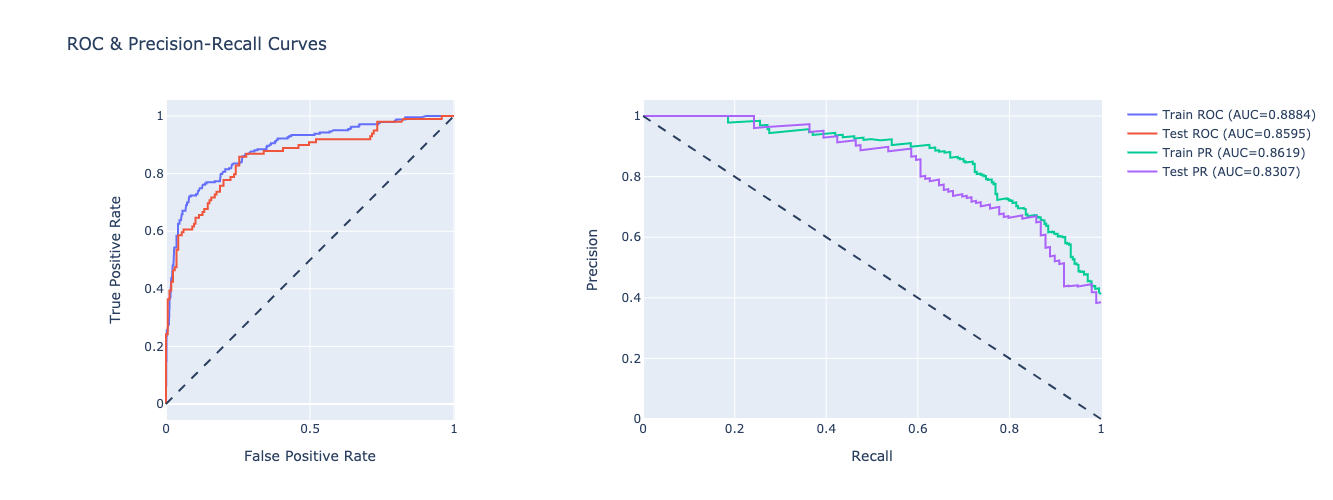

In [9]:
print(clf.evaluate(x_test, y_test))

model = clf.export_model()
model.summary()

y_score = model.predict(x_test.astype(np.unicode))
y_score_train = model.predict(x_train.astype(np.unicode))

plot_pr_train_test(y_train, y_score_train, y_test, y_score)

The following code shows how to convert numpy.ndarray to tf.data.Dataset.


In [10]:
train_set = tf.data.Dataset.from_tensor_slices((x_train.astype(np.unicode), y_train))
test_set = tf.data.Dataset.from_tensor_slices(
    (x_test.to_numpy().astype(np.unicode), y_test)
)

clf = ak.StructuredDataClassifier(overwrite=True, max_trials=3)
# Feed the tensorflow Dataset to the classifier.
clf.fit(train_set, epochs=10)
# Predict with the best model.
predicted_y = clf.predict(test_set)
# Evaluate the best model with testing data.
print(clf.evaluate(test_set))


Trial 3 Complete [00h 00m 02s]
val_accuracy: 0.8782608509063721

Best val_accuracy So Far: 0.886956512928009
Total elapsed time: 00h 00m 07s
Epoch 1/10
20/20 [==============================] - 0s 2ms/step - loss: 0.7061 - accuracy: 0.4828
Epoch 2/10
20/20 [==============================] - 0s 2ms/step - loss: 0.6197 - accuracy: 0.7375
Epoch 3/10
20/20 [==============================] - 0s 2ms/step - loss: 0.5622 - accuracy: 0.7791
Epoch 4/10
20/20 [==============================] - 0s 2ms/step - loss: 0.5175 - accuracy: 0.7911
Epoch 5/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4859 - accuracy: 0.8006
Epoch 6/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4655 - accuracy: 0.8071
Epoch 7/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4530 - accuracy: 0.8224
Epoch 8/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4446 - accuracy: 0.8217
Epoch 9/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4

You can also specify the column names and types for the data as follows.  The `column_names` is optional if the training data already have the column names, e.g.  pandas.DataFrame, CSV file.  Any column, whose type is not specified will be inferred from the training data.


In [11]:
# Initialize the structured data classifier.
clf = ak.StructuredDataClassifier(
    column_names=[
        "sex",
        "age",
        "n_siblings_spouses",
        "parch",
        "fare",
        "class",
        "deck",
        "embark_town",
        "alone",
    ],
    column_types={"sex": "categorical", "fare": "numerical"},
    max_trials=10,  # It tries 10 different models.
    overwrite=True,
)


## Validation Data
By default, AutoKeras use the last 20% of training data as validation data.  As
shown in the example below, you can use `validation_split` to specify the
percentage.


In [12]:
clf.fit(
    x_train,
    y_train,
    # Split the training data and use the last 15% as validation data.
    validation_split=0.15,
    epochs=10,
)
display(hyper_table())

Trial 10 Complete [00h 00m 02s]
val_accuracy: 0.891566276550293

Best val_accuracy So Far: 0.891566276550293
Total elapsed time: 00h 00m 23s
Epoch 1/10
20/20 [==============================] - 1s 1ms/step - loss: 0.8565 - accuracy: 0.4842
Epoch 2/10
20/20 [==============================] - 0s 1ms/step - loss: 0.6424 - accuracy: 0.6159
Epoch 3/10
20/20 [==============================] - 0s 1ms/step - loss: 0.5471 - accuracy: 0.7348
Epoch 4/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4943 - accuracy: 0.7886
Epoch 5/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4648 - accuracy: 0.8136
Epoch 6/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4470 - accuracy: 0.8213
Epoch 7/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4351 - accuracy: 0.8275
Epoch 8/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4260 - accuracy: 0.8245
Epoch 9/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4

trial#1  trial#2  \
structured_data_block_1/normalize                       True     True   
structured_data_block_1/dense_block_1/use_batch...      True    False   
structured_data_block_1/dense_block_1/num_layers           2        2   
structured_data_block_1/dense_block_1/units_0             32       32   
structured_data_block_1/dense_block_1/dropout              0        0   
structured_data_block_1/dense_block_1/units_1             32       32   
classification_head_1/dropout                              0        0   
optimizer                                               adam     adam   
learning_rate                                          0.001    0.001   
score                                               0.891566  0.86747   
structured_data_block_1/dense_block_1/units_2            NaN      NaN   

                                                    trial#3   trial#4  \
structured_data_block_1/normalize                      True      True   
structured_data_block_1/dense_block_1/use_batch...    False      True   
structured_data_block_1/dense_block_1/num_layers          2         2   
structured_data_block_1/dense_block_1/units_0            32        32   
structured_data_block_1/dense_block_1/dropout             0         0   
structured_data_block_1/dense_block_1/units_1            32        32   
classification_head_1/dropout                             0         0   
optimizer                                              adam      adam   
learning_rate                                         0.001     0.001   
score                                               0.86747  0.891566   
structured_data_block_1/dense_block_1/units_2           NaN      1024   

                                                     trial#5   trial#6  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...      True     False   
structured_data_block_1/dense_block_1/num_layers           2         3   
structured_data_block_1/dense_block_1/units_0             32       256   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32       128   
classification_head_1/dropout                              0      0.25   
optimizer                                               adam      adam   
learning_rate                                            0.1    0.0001   
score                                               0.891566  0.879518   
structured_data_block_1/dense_block_1/units_2            NaN        32   

                                                    trial#7   trial#8  \
structured_data_block_1/normalize                      True      True   
structured_data_block_1/dense_block_1/use_batch...     True      True   
structured_data_block_1/dense_block_1/num_layers          2         2   
structured_data_block_1/dense_block_1/units_0            32        32   
structured_data_block_1/dense_block_1/dropout           0.5      0.25   
structured_data_block_1/dense_block_1/units_1            32        32   
classification_head_1/dropout                             0         0   
optimizer                                              adam      adam   
learning_rate                                         0.001     0.001   
score                                               0.86747  0.879518   
structured_data_block_1/dense_block_1/units_2           NaN        64   

                                                     trial#9 trial#10  
structured_data_block_1/normalize                       True     True  
structured_data_block_1/dense_block_1/use_batch...      True     True  
structured_data_block_1/dense_block_1/num_layers           2        2  
structured_data_block_1/dense_block_1/units_0             32       32  
structured_data_block_1/dense_block_1/dropout              0        0  
structured_data_block_1/dense_block_1/units_1             32       32  
classification_head_1/dropout

You can also use your own validation set
instead of splitting it from the training data with `validation_data`.


In [13]:
split = 500
x_val = x_train[split:]
y_val = y_train[split:]
x_train = x_train[:split]
y_train = y_train[:split]
clf.fit(
    x_train,
    y_train,
    # Use your own validation set.
    validation_data=(x_val, y_val),
    epochs=10,
)

## Customized Search Space
For advanced users, you may customize your search space by using
[AutoModel](/auto_model/#automodel-class) instead of
[StructuredDataClassifier](/structured_data_classifier). You can configure the
[StructuredDataBlock](/block/#structureddatablock-class) for some high-level
configurations, e.g., `categorical_encoding` for whether to use the
[CategoricalToNumerical](/block/#categoricaltonumerical-class). You can also do
not specify these arguments, which would leave the different choices to be
tuned automatically. See the following example for detail.


Trial 3 Complete [00h 00m 02s]
val_loss: 0.5375258326530457

Best val_loss So Far: 0.5227101445198059
Total elapsed time: 00h 00m 05s
Epoch 1/10
16/16 [==============================] - 0s 1ms/step - loss: 4.2853 - accuracy: 0.3849
Epoch 2/10
16/16 [==============================] - 0s 1ms/step - loss: 0.9893 - accuracy: 0.6154
Epoch 3/10
16/16 [==============================] - 0s 1ms/step - loss: 0.8241 - accuracy: 0.6217
Epoch 4/10
16/16 [==============================] - 0s 1ms/step - loss: 0.7129 - accuracy: 0.5887
Epoch 5/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6718 - accuracy: 0.6260
Epoch 6/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6536 - accuracy: 0.6485
Epoch 7/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6569 - accuracy: 0.6511
Epoch 8/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6490 - accuracy: 0.6513
Epoch 9/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6440 - a

trial#1   trial#2  \
structured_data_block_1/normalize                      False     False   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0      0.25   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                                sgd      adam   
learning_rate                                          0.001     0.001   
score                                               0.549869  0.537526   

                                                    trial#3  
structured_data_block_1/normalize                     False  
structured_data_block_1/dense_block_1/use_batch...    False  
structured_data_block_1/dense_block_1/num_layers          2  
structured_data_block_1/dense_block_1/units_0            32  
structured_data_block_1/dense_block_1/dropout             0  
structured_data_block_1/dense_block_1/units_1            32  
classification_head_1/dropout                             0  
optimizer                                              adam  
learning_rate                                         0.001  
score                                               0.52271

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 9)                 0         
_________________________________________________________________
dense (Dense)                (None, 32)                320       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33    

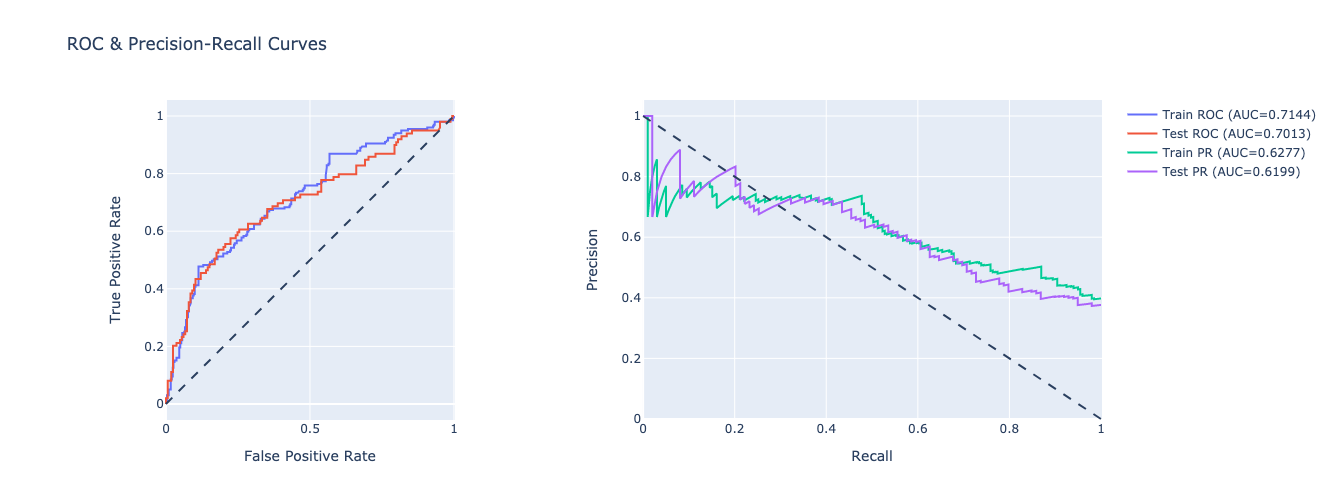

In [14]:

input_node = ak.StructuredDataInput()
output_node = ak.StructuredDataBlock(categorical_encoding=True)(input_node)
#output_node = ak.DenseBlock(num_layers=1, num_units=64, use_batchnorm=None, dropout=None)(output_node)
#output_node = ak.DenseBlock(num_layers=1, num_units=32, use_batchnorm=True, dropout=0.5)(output_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=3
)
clf.fit(x_train, y_train, epochs=10)
clf.evaluate(x_test, y_test)

display(hyper_table('auto_model'))

model = clf.export_model()
model.summary()

y_score = model.predict(x_test.astype(np.unicode))
y_score_train = model.predict(x_train.astype(np.unicode))

plot_pr_train_test(y_train, y_score_train, y_test, y_score)

The usage of [AutoModel](/auto_model/#automodel-class) is similar to the
[functional API](https://www.tensorflow.org/guide/keras/functional) of Keras.
Basically, you are building a graph, whose edges are blocks and the nodes are
intermediate outputs of blocks.
To add an edge from `input_node` to `output_node` with
`output_node = ak.[some_block]([block_args])(input_node)`.

You can even also use more fine grained blocks to customize the search space even
further. See the following example.


In [15]:
input_node = ak.StructuredDataInput()
output_node = ak.CategoricalToNumerical()(input_node)
output_node = ak.DenseBlock()(output_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=10
)
clf.fit(x_train, y_train, epochs=10)
clf.evaluate(x_test, y_test)
display(hyper_table('auto_model'))

Trial 10 Complete [00h 00m 02s]
val_loss: 0.525148868560791

Best val_loss So Far: 0.5104568004608154
Total elapsed time: 00h 00m 20s
Epoch 1/10
16/16 [==============================] - 0s 1ms/step - loss: 4.8600 - accuracy: 0.5078
Epoch 2/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6955 - accuracy: 0.3834
Epoch 3/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6911 - accuracy: 0.6234
Epoch 4/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6847 - accuracy: 0.6234
Epoch 5/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6791 - accuracy: 0.6234
Epoch 6/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6747 - accuracy: 0.6234
Epoch 7/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6714 - accuracy: 0.6234
Epoch 8/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6691 - accuracy: 0.6234
Epoch 9/10
16/16 [==============================] - 0s 2ms/step - loss: 0.6674 - a

trial#1   trial#2   trial#3   trial#4  \
dense_block_2/use_batchnorm       False     False     False     False   
dense_block_2/num_layers              2         2         1         2   
dense_block_2/units_0              1024      1024      1024      1024   
dense_block_2/dropout                 0         0         0         0   
dense_block_2/units_1                32       128        32        32   
classification_head_1/dropout         0         0         0         0   
optimizer                          adam      adam      adam      adam   
learning_rate                      0.01      0.01      0.01     0.001   
dense_block_2/units_2                32        32       NaN       NaN   
score                          0.674896  0.525149  0.518604  0.513418   

                                trial#5   trial#6   trial#7 trial#8   trial#9  \
dense_block_2/use_batchnorm       False     False     False   False     False   
dense_block_2/num_layers              2         2         2       2         3   
dense_block_2/units_0              1024      1024      1024    1024      1024   
dense_block_2/dropout                 0         0         0       0         0   
dense_block_2/units_1                32        32        32      32        32   
classification_head_1/dropout         0         0      0.25       0         0   
optimizer                          adam      adam      adam    adam      adam   
learning_rate                      0.01     2e-05      0.01    0.01      0.01   
dense_block_2/units_2               NaN       256        64     256        32   
score                          0.563253  0.566409  0.674907  0.6749  0.558366   

                               trial#10  
dense_block_2/use_batchnorm       False  
dense_block_2/num_layers              2  
dense_block_2/units_0              1024  
dense_block_2/dropout                 0  
dense_block_2/units_1                32  
classification_head_1/dropout         0  
optimizer                          adam  
learning_rate                      0.01  
dense_block_2/units_2               NaN  
score                          0.510457

You can also export the best model found by AutoKeras as a Keras Model.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 9)                 0         
_________________________________________________________________
dense (Dense)                (None, 1024)              10240     
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                32800     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33    

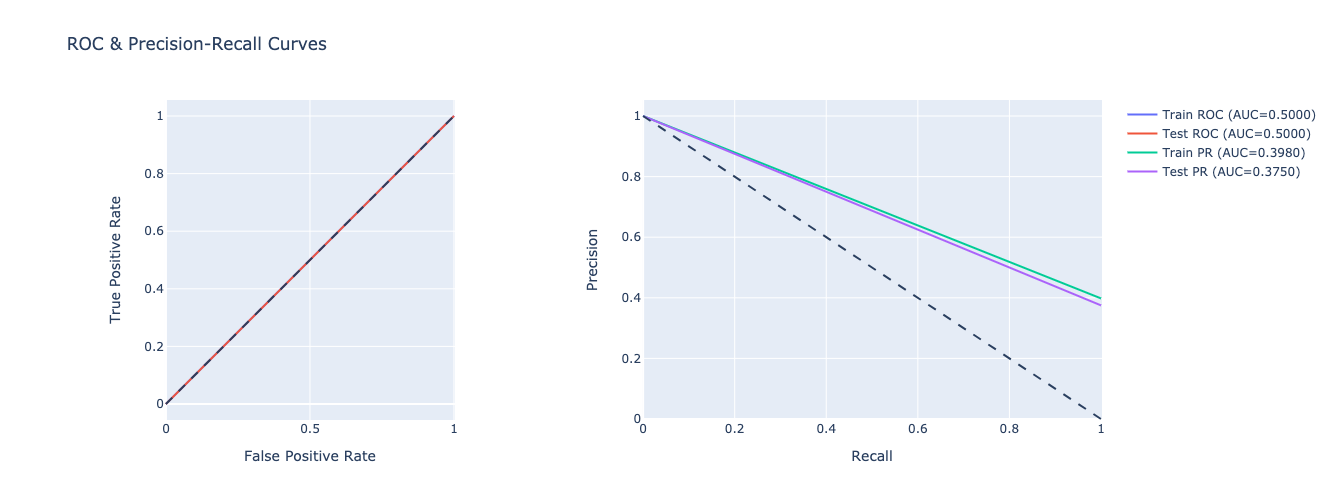

In [16]:
model = clf.export_model()
model.summary()

y_score = model.predict(x_test.astype(np.unicode))
y_score_train = model.predict(x_train.astype(np.unicode))

plot_pr_train_test(y_train, y_score_train, y_test, y_score)

In [17]:
print(x_train.dtype)
# numpy array in object (mixed type) is not supported.
# convert it to unicode.
y_predict_score = model.predict(x_train.astype(np.unicode))

object


In [18]:
Y_Scores = []
Y_Scores_train = []
Accuracies = []
Accuracies_train = []
Hyper_dfs = []
for it in range(5,16):
    # It tries 30 different models.
    clf = ak.StructuredDataClassifier(overwrite=True, max_trials=it)
    # Feed the structured data classifier with training data.
    clf.fit(x_train, y_train, epochs=10)
    # Predict with the best model.
    predicted_y = clf.predict(x_test)
    # Evaluate the best model with testing data.
    Accuracies.append(clf.evaluate(x_test, y_test)[1])
    Accuracies_train.append(clf.evaluate(x_train, y_train)[1])

    Hyper_dfs.append(hyper_table())
    
    model = clf.export_model()
    y_score = model.predict(x_test.astype(np.unicode))
    Y_Scores.append(y_score)
    y_score_train = model.predict(x_train.astype(np.unicode))
    Y_Scores_train.append(y_score_train)

Trial 15 Complete [00h 00m 02s]
val_accuracy: 0.7976190447807312

Best val_accuracy So Far: 0.8690476417541504
Total elapsed time: 00h 00m 32s
Epoch 1/10
16/16 [==============================] - 0s 1ms/step - loss: 0.9636 - accuracy: 0.5471
Epoch 2/10
16/16 [==============================] - 0s 1ms/step - loss: 1.3723 - accuracy: 0.5411
Epoch 3/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6866 - accuracy: 0.6578
Epoch 4/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6439 - accuracy: 0.6952
Epoch 5/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6367 - accuracy: 0.7092
Epoch 6/10
16/16 [==============================] - 0s 1ms/step - loss: 0.8179 - accuracy: 0.6666
Epoch 7/10
16/16 [==============================] - 0s 1ms/step - loss: 0.5898 - accuracy: 0.7354
Epoch 8/10
16/16 [==============================] - 0s 1ms/step - loss: 0.5541 - accuracy: 0.7449
Epoch 9/10
16/16 [==============================] - 0s 1ms/step - loss: 0

In [19]:
Accuracies

[0.7954545617103577,
 0.7954545617103577,
 0.7234848737716675,
 0.7878788113594055,
 0.8068181872367859,
 0.7992424368858337,
 0.7992424368858337,
 0.7840909361839294,
 0.7916666865348816,
 0.7159090638160706,
 0.7575757503509521]

In [20]:
Accuracies_train

[0.828000009059906,
 0.8180000185966492,
 0.7039999961853027,
 0.8159999847412109,
 0.8339999914169312,
 0.7879999876022339,
 0.8040000200271606,
 0.8259999752044678,
 0.8140000104904175,
 0.6959999799728394,
 0.7540000081062317]

* ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.
* Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.
* ROC curves are appropriate when the __observations are balanced between each class__, whereas precision-recall curves are appropriate for __imbalanced datasets__.

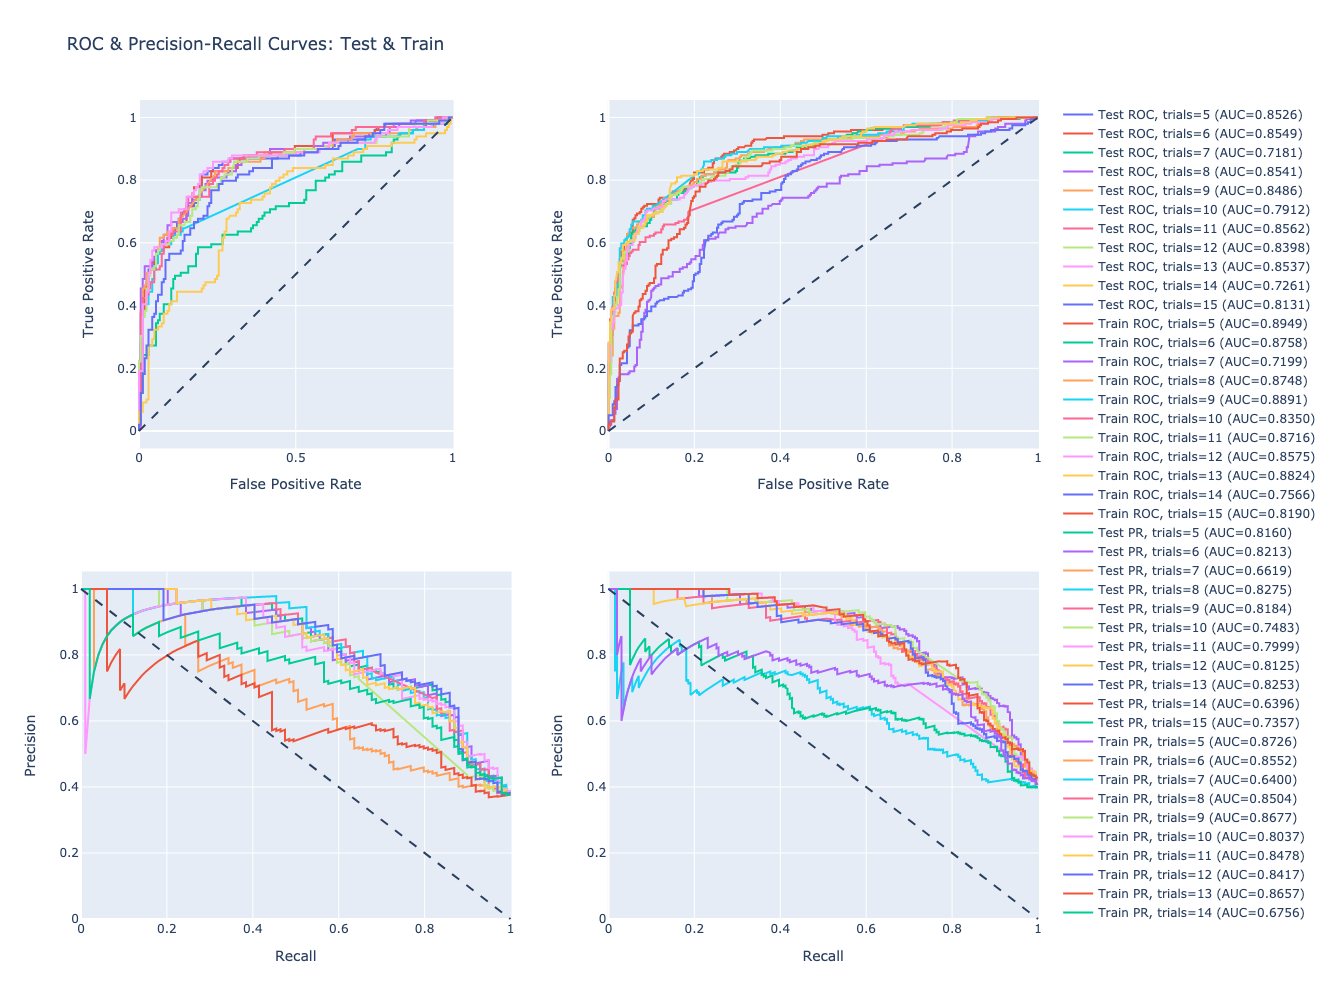

trial#1   trial#2  \
structured_data_block_1/normalize                     True      True   
structured_data_block_1/dense_block_1/num_layers         2         2   
structured_data_block_1/dense_block_1/use_batch...   False     False   
structured_data_block_1/dense_block_1/dropout            0         0   
structured_data_block_1/dense_block_1/units_0           32        32   
structured_data_block_1/dense_block_1/units_1           32       256   
classification_head_1/dropout                            0         0   
optimizer                                             adam      adam   
learning_rate                                        0.001     0.001   
score                                                 0.75  0.797619   

                                                     trial#3   trial#4  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/use_batch...     False      True   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/units_1            512       512   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
score                                               0.785714  0.761905   

                                                     trial#5  
structured_data_block_1/normalize                       True  
structured_data_block_1/dense_block_1/num_layers           2  
structured_data_block_1/dense_block_1/use_batch...     False  
structured_data_block_1/dense_block_1/dropout              0  
structured_data_block_1/dense_block_1/units_0             32  
structured_data_block_1/dense_block_1/units_1            256  
classification_head_1/dropout                              0  
optimizer                                                sgd  
learning_rate                                          0.001  
score                                               0.630952

trial#1   trial#2  \
structured_data_block_1/normalize                      True      True   
structured_data_block_1/dense_block_1/use_batch...    False      True   
structured_data_block_1/dense_block_1/num_layers          2         2   
structured_data_block_1/dense_block_1/units_0            16        32   
structured_data_block_1/dense_block_1/dropout             0         0   
structured_data_block_1/dense_block_1/units_1            32        32   
classification_head_1/dropout                             0         0   
optimizer                                              adam      adam   
learning_rate                                         0.001     0.001   
structured_data_block_1/dense_block_1/units_2           256       512   
score                                               0.77381  0.761905   

                                                     trial#3   trial#4  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
structured_data_block_1/dense_block_1/units_2             64       NaN   
score                                               0.738095  0.785714   

                                                    trial#5  trial#6  
structured_data_block_1/normalize                      True     True  
structured_data_block_1/dense_block_1/use_batch...    False    False  
structured_data_block_1/dense_block_1/num_layers          2        3  
structured_data_block_1/dense_block_1/units_0            32       32  
structured_data_block_1/dense_block_1/dropout             0        0  
structured_data_block_1/dense_block_1/units_1            32       32  
classification_head_1/dropout                             0        0  
optimizer                                              adam     adam  
learning_rate                                         0.001    0.001  
structured_data_block_1/dense_block_1/units_2           512       32  
score                                               0.77381  0.77381

trial#1 trial#2  \
structured_data_block_1/normalize                      False    True   
structured_data_block_1/dense_block_1/use_batch...     False    True   
structured_data_block_1/dense_block_1/num_layers           2       2   
structured_data_block_1/dense_block_1/units_0             32      32   
structured_data_block_1/dense_block_1/dropout              0       0   
structured_data_block_1/dense_block_1/units_1             32      32   
classification_head_1/dropout                              0       0   
optimizer                                               adam    adam   
learning_rate                                          0.001   0.001   
score                                               0.785714    0.75   

                                                     trial#3   trial#4  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          1e-05     0.001   
score                                               0.452381  0.761905   

                                                     trial#5   trial#6  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                                sgd      adam   
learning_rate                                          0.001     0.001   
score                                               0.607143  0.761905   

                                                     trial#7  
structured_data_block_1/normalize                       True  
structured_data_block_1/dense_block_1/use_batch...     False  
structured_data_block_1/dense_block_1/num_layers           1  
structured_data_block_1/dense_block_1/units_0             32  
structured_data_block_1/dense_block_1/dropout              0  
structured_data_block_1/dense_block_1/units_1             32  
classification_head_1/dropout                              0  
optimizer                                               adam  
learning_rate                                          0.001  
score                                               0.761905

trial#1  \
structured_data_block_1/normalize                                True   
structured_data_block_1/dense_block_1/use_batch...              False   
structured_data_block_1/dense_block_1/num_layers                    2   
structured_data_block_1/dense_block_1/units_0                      32   
structured_data_block_1/dense_block_1/dropout                       0   
structured_data_block_1/dense_block_1/units_1                      32   
classification_head_1/dropout                                       0   
optimizer                                           adam_weight_decay   
learning_rate                                                   0.001   
score                                                            0.75   

                                                     trial#2   trial#3  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0           1024        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          0.001     2e-05   
score                                               0.761905  0.619048   

                                                     trial#4  trial#5  \
structured_data_block_1/normalize                       True     True   
structured_data_block_1/dense_block_1/use_batch...     False    False   
structured_data_block_1/dense_block_1/num_layers           2        2   
structured_data_block_1/dense_block_1/units_0             32       32   
structured_data_block_1/dense_block_1/dropout            0.5        0   
structured_data_block_1/dense_block_1/units_1             32      256   
classification_head_1/dropout                              0        0   
optimizer                                               adam     adam   
learning_rate                                          0.001    0.001   
score                                               0.761905  0.77381   

                                                     trial#6   trial#7  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             16        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
score                                               0.761905  0.809524   

                                                     trial#8  
structured_data_block_1/normalize                       True  
structured_data_block_1/dense_block_1/use_batch...     False  
structured_data_block_1/dense_block_1/num_layers           2  
structured_data_block_1/dense_block_1/units_0             32  
structured_data_block_1/dense_block_1/dropout              0  
structured_data_block_1/dense_block_1/units_1             32  
classification_head_1/dropout                              0  
optimizer                                                sgd  
learning_rate                                          0.001  
score                                               0.345238

trial#1   trial#2  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0       0.5   
optimizer                                               adam      adam   
learning_rate                                            0.1     0.001   
score                                               0.797619  0.761905   

                                                     trial#3   trial#4  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                           0.25         0   
optimizer                                               adam      adam   
learning_rate                                          0.001    0.0001   
score                                               0.761905  0.666667   

                                                     trial#5   trial#6  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout           0.25         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
score                                               0.785714  0.785714   

                                                    trial#7   trial#8  \
structured_data_block_1/normalize                      True      True   
structured_data_block_1/dense_block_1/use_batch...    False     False   
structured_data_block_1/dense_block_1/num_layers          2         1   
structured_data_block_1/dense_block_1/units_0            32        32   
structured_data_block_1/dense_block_1/dropout             0         0   
structured_data_block_1/dense_block_1/units_1            32        32   
classification_head_1/dropout                             0         0   
optimizer                                              adam      adam   
learning_rate                                         0.001     0.001   
score                                               0.72619  0.738095   

                                                     trial#9  
structured_data_block_1/normalize                       True  
structured_data_block_1/dense_block_1/use_batch...     False  
structured_data_block_1/dense_block_1/num_layers           2  
structured_data_block_1/dense_block_1/units_0            256  
structured_data_block_1/dense_block_1/dropout              0  
structured_data_block_1/dense_block_1/units_1             32  
classification_head_1/dropout                            0.5  
optimizer                                               adam  
learning_rate                                          0.001  
score                                               0.761905

trial#1  trial#2 trial#3  \
structured_data_block_1/normalize                       True     True    True   
structured_data_block_1/dense_block_1/use_batch...     False     True   False   
structured_data_block_1/dense_block_1/num_layers           2        2       2   
structured_data_block_1/dense_block_1/units_0             32       32      32   
structured_data_block_1/dense_block_1/dropout              0        0       0   
structured_data_block_1/dense_block_1/units_1             32       32      64   
classification_head_1/dropout                            0.5      0.5     0.5   
optimizer                                               adam     adam    adam   
learning_rate                                            0.1      0.1   0.001   
score                                               0.797619  0.77381    0.75   

                                                    trial#4  \
structured_data_block_1/normalize                      True   
structured_data_block_1/dense_block_1/use_batch...    False   
structured_data_block_1/dense_block_1/num_layers          1   
structured_data_block_1/dense_block_1/units_0           512   
structured_data_block_1/dense_block_1/dropout           0.5   
structured_data_block_1/dense_block_1/units_1          1024   
classification_head_1/dropout                           0.5   
optimizer                                              adam   
learning_rate                                         0.001   
score                                               0.77381   

                                                              trial#5  \
structured_data_block_1/normalize                                True   
structured_data_block_1/dense_block_1/use_batch...              False   
structured_data_block_1/dense_block_1/num_layers                    2   
structured_data_block_1/dense_block_1/units_0                      32   
structured_data_block_1/dense_block_1/dropout                       0   
structured_data_block_1/dense_block_1/units_1                      32   
classification_head_1/dropout                                     0.5   
optimizer                                           adam_weight_decay   
learning_rate                                                   0.001   
score                                                        0.666667   

                                                     trial#6  trial#7  \
structured_data_block_1/normalize                       True     True   
structured_data_block_1/dense_block_1/use_batch...     False    False   
structured_data_block_1/dense_block_1/num_layers           1        2   
structured_data_block_1/dense_block_1/units_0             32       32   
structured_data_block_1/dense_block_1/dropout              0        0   
structured_data_block_1/dense_block_1/units_1             32       16   
classification_head_1/dropout                              0      0.5   
optimizer                                               adam     adam   
learning_rate                                          0.001    0.001   
score                                               0.666667  0.77381   

                                                    trial#8   trial#9  \
structured_data_block_1/normalize                      True      True   
structured_data_block_1/dense_block_1/use_batch...     True     False   
structured_data_block_1/dense_block_1/num_layers          2         2   
structured_data_block_1/dense_block_1/units_0            32        32   
structured_data_block_1/dense_block_1/dropout             0         0   
structured_data_block_1/dense_block_1/units_1            32        32   
classification_head_1/dropout                           0.5         0   
optimizer                                              adam      adam   
learning_rate                                         0.001     0.001   
score                                               0.72619  0.761905   

                                                    tri

trial#1  trial#2  \
structured_data_block_1/normalize                       True     True   
structured_data_block_1/dense_block_1/num_layers           2        2   
structured_data_block_1/dense_block_1/use_batch...     False    False   
structured_data_block_1/dense_block_1/dropout              0        0   
structured_data_block_1/dense_block_1/units_0             32       32   
structured_data_block_1/dense_block_1/units_1             32       32   
classification_head_1/dropout                              0     0.25   
optimizer                                               adam     adam   
learning_rate                                          0.001    0.001   
score                                               0.785714  0.77381   

                                                    trial#3   trial#4  \
structured_data_block_1/normalize                     False      True   
structured_data_block_1/dense_block_1/num_layers          2         2   
structured_data_block_1/dense_block_1/use_batch...    False     False   
structured_data_block_1/dense_block_1/dropout             0         0   
structured_data_block_1/dense_block_1/units_0            32        32   
structured_data_block_1/dense_block_1/units_1            32        32   
classification_head_1/dropout                             0         0   
optimizer                                              adam      adam   
learning_rate                                         0.001     0.001   
score                                               0.72619  0.761905   

                                                     trial#5  trial#6  \
structured_data_block_1/normalize                       True     True   
structured_data_block_1/dense_block_1/num_layers           2        2   
structured_data_block_1/dense_block_1/use_batch...     False    False   
structured_data_block_1/dense_block_1/dropout              0        0   
structured_data_block_1/dense_block_1/units_0             32       32   
structured_data_block_1/dense_block_1/units_1             64       32   
classification_head_1/dropout                              0      0.5   
optimizer                                               adam     adam   
learning_rate                                          0.001    0.001   
score                                               0.785714  0.77381   

                                                    trial#7   trial#8  \
structured_data_block_1/normalize                      True      True   
structured_data_block_1/dense_block_1/num_layers          2         2   
structured_data_block_1/dense_block_1/use_batch...    False     False   
structured_data_block_1/dense_block_1/dropout           0.5         0   
structured_data_block_1/dense_block_1/units_0            32      1024   
structured_data_block_1/dense_block_1/units_1            32        32   
classification_head_1/dropout                             0         0   
optimizer                                              adam      adam   
learning_rate                                         0.001     0.001   
score                                               0.77381  0.761905   

                                                     trial#9  trial#10  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_0            128        32   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam       sgd   
learning_rate                                          0.001     0.001   
score                                               0.761905  0.654762   

                      

trial#1   trial#2  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             64      1024   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
score                                               0.785714  0.761905   
structured_data_block_1/dense_block_1/units_2            NaN       256   

                                                     trial#3 trial#4  \
structured_data_block_1/normalize                       True    True   
structured_data_block_1/dense_block_1/use_batch...     False   False   
structured_data_block_1/dense_block_1/num_layers           2       2   
structured_data_block_1/dense_block_1/units_0             32      32   
structured_data_block_1/dense_block_1/dropout              0       0   
structured_data_block_1/dense_block_1/units_1             32      32   
classification_head_1/dropout                              0     0.5   
optimizer                                               adam    adam   
learning_rate                                          1e-05   0.001   
score                                               0.595238    0.75   
structured_data_block_1/dense_block_1/units_2            128      32   

                                                     trial#5   trial#6  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
score                                               0.785714  0.785714   
structured_data_block_1/dense_block_1/units_2            NaN       128   

                                                    trial#7  trial#8  \
structured_data_block_1/normalize                      True     True   
structured_data_block_1/dense_block_1/use_batch...    False    False   
structured_data_block_1/dense_block_1/num_layers          2        2   
structured_data_block_1/dense_block_1/units_0            32       32   
structured_data_block_1/dense_block_1/dropout           0.5        0   
structured_data_block_1/dense_block_1/units_1            32       32   
classification_head_1/dropout                             0        0   
optimizer                                              adam     adam   
learning_rate                                         0.001    0.001   
score                                               0.77381  0.77381   
structured_data_block_1/dense_block_1/units_2           NaN      512   

                                                     trial#9  trial#10  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           3         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropo

trial#1  trial#2  \
structured_data_block_1/normalize                       True    False   
structured_data_block_1/dense_block_1/use_batch...      True     True   
structured_data_block_1/dense_block_1/num_layers           2        2   
structured_data_block_1/dense_block_1/units_0             32       32   
structured_data_block_1/dense_block_1/dropout              0        0   
structured_data_block_1/dense_block_1/units_1             32       32   
classification_head_1/dropout                              0        0   
optimizer                                               adam     adam   
learning_rate                                          0.001    0.001   
structured_data_block_1/dense_block_1/units_2             16     1024   
score                                               0.761905  0.72619   

                                                    trial#3  trial#4  \
structured_data_block_1/normalize                      True     True   
structured_data_block_1/dense_block_1/use_batch...     True     True   
structured_data_block_1/dense_block_1/num_layers          2        2   
structured_data_block_1/dense_block_1/units_0            32       32   
structured_data_block_1/dense_block_1/dropout             0        0   
structured_data_block_1/dense_block_1/units_1           512       32   
classification_head_1/dropout                             0        0   
optimizer                                              adam     adam   
learning_rate                                         0.001    0.001   
structured_data_block_1/dense_block_1/units_2            64       32   
score                                               0.77381  0.77381   

                                                     trial#5  \
structured_data_block_1/normalize                       True   
structured_data_block_1/dense_block_1/use_batch...     False   
structured_data_block_1/dense_block_1/num_layers           2   
structured_data_block_1/dense_block_1/units_0             32   
structured_data_block_1/dense_block_1/dropout              0   
structured_data_block_1/dense_block_1/units_1             32   
classification_head_1/dropout                              0   
optimizer                                               adam   
learning_rate                                          0.001   
structured_data_block_1/dense_block_1/units_2            NaN   
score                                               0.797619   

                                                              trial#6  \
structured_data_block_1/normalize                                True   
structured_data_block_1/dense_block_1/use_batch...               True   
structured_data_block_1/dense_block_1/num_layers                    2   
structured_data_block_1/dense_block_1/units_0                     256   
structured_data_block_1/dense_block_1/dropout                       0   
structured_data_block_1/dense_block_1/units_1                     512   
classification_head_1/dropout                                    0.25   
optimizer                                           adam_weight_decay   
learning_rate                                                     0.1   
structured_data_block_1/dense_block_1/units_2                     NaN   
score                                                         0.77381   

                                                     trial#7   trial#8  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...      True      True   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   

trial#1   trial#2  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0       0.5   
optimizer                                               adam      adam   
learning_rate                                         0.0001    0.0001   
score                                               0.630952  0.595238   
structured_data_block_1/dense_block_1/units_2            NaN      1024   

                                                     trial#3  trial#4  \
structured_data_block_1/normalize                       True     True   
structured_data_block_1/dense_block_1/use_batch...     False    False   
structured_data_block_1/dense_block_1/num_layers           1        2   
structured_data_block_1/dense_block_1/units_0             32       32   
structured_data_block_1/dense_block_1/dropout              0        0   
structured_data_block_1/dense_block_1/units_1             32      512   
classification_head_1/dropout                              0        0   
optimizer                                               adam     adam   
learning_rate                                         0.0001   0.0001   
score                                               0.714286  0.77381   
structured_data_block_1/dense_block_1/units_2            NaN      512   

                                                     trial#5   trial#6  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                            0.5         0   
optimizer                                               adam      adam   
learning_rate                                         0.0001    0.0001   
score                                               0.595238  0.654762   
structured_data_block_1/dense_block_1/units_2             16        32   

                                                    trial#7   trial#8  \
structured_data_block_1/normalize                      True     False   
structured_data_block_1/dense_block_1/use_batch...    False     False   
structured_data_block_1/dense_block_1/num_layers          2         2   
structured_data_block_1/dense_block_1/units_0          1024        32   
structured_data_block_1/dense_block_1/dropout             0         0   
structured_data_block_1/dense_block_1/units_1            32        32   
classification_head_1/dropout                             0         0   
optimizer                                              adam      adam   
learning_rate                                        0.0001    0.0001   
score                                               0.77381  0.583333   
structured_data_block_1/dense_block_1/units_2            32       512   

                                                     trial#9 trial#10  \
structured_data_block_1/normalize                       True     True   
structured_data_block_1/dense_block_1/use_batch...     False    False   
structured_data_block_1/dense_block_1/num_layers           2        2   
structured_data_block_1/dense_block_1/units_0            256       32   
structured_data_block_1/dense_block_1/dropout              0        0   
structured_data_block_1/dense_block_1/units_1             32       32   
classifica

trial#1  \
structured_data_block_1/normalize                       True   
structured_data_block_1/dense_block_1/num_layers           2   
structured_data_block_1/dense_block_1/use_batch...     False   
structured_data_block_1/dense_block_1/dropout              0   
structured_data_block_1/dense_block_1/units_0             32   
structured_data_block_1/dense_block_1/units_1             32   
classification_head_1/dropout                              0   
optimizer                                               adam   
learning_rate                                          0.001   
score                                               0.761905   
structured_data_block_1/dense_block_1/units_2            NaN   

                                                              trial#2  \
structured_data_block_1/normalize                               False   
structured_data_block_1/dense_block_1/num_layers                    2   
structured_data_block_1/dense_block_1/use_batch...              False   
structured_data_block_1/dense_block_1/dropout                       0   
structured_data_block_1/dense_block_1/units_0                     256   
structured_data_block_1/dense_block_1/units_1                      32   
classification_head_1/dropout                                       0   
optimizer                                           adam_weight_decay   
learning_rate                                                    0.01   
score                                                        0.833333   
structured_data_block_1/dense_block_1/units_2                    1024   

                                                              trial#3  \
structured_data_block_1/normalize                               False   
structured_data_block_1/dense_block_1/num_layers                    2   
structured_data_block_1/dense_block_1/use_batch...              False   
structured_data_block_1/dense_block_1/dropout                       0   
structured_data_block_1/dense_block_1/units_0                     256   
structured_data_block_1/dense_block_1/units_1                      32   
classification_head_1/dropout                                       0   
optimizer                                           adam_weight_decay   
learning_rate                                                    0.01   
score                                                        0.666667   
structured_data_block_1/dense_block_1/units_2                     256   

                                                              trial#4  \
structured_data_block_1/normalize                               False   
structured_data_block_1/dense_block_1/num_layers                    3   
structured_data_block_1/dense_block_1/use_batch...              False   
structured_data_block_1/dense_block_1/dropout                       0   
structured_data_block_1/dense_block_1/units_0                     256   
structured_data_block_1/dense_block_1/units_1                      32   
classification_head_1/dropout                                       0   
optimizer                                           adam_weight_decay   
learning_rate                                                    0.01   
score                                                        0.666667   
structured_data_block_1/dense_block_1/units_2                      32   

                                                     trial#5  \
structured_data_block_1/normalize                      False   
structured_data_block_1/dense_block_1/num_layers           2   
structured_data_block_1/dense_block_1/use_batch...     False   
structured_data_block_1/dense_block_1/dropout              0   
structured_data_block_1/dense_block_1/units_0             32   
structured_data_block_1/dense_block_1/units_1             32   
classification_head_1/dropout                              0   
optimizer                                               adam   
learning_rate                                           0.01   
score        

[None, None, None, None, None, None, None, None, None, None, None]

In [22]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score
from plotly.subplots import make_subplots

#fig = go.Figure()
fig = make_subplots(rows=2, cols=2)

# subplot 1: ROC curve Testing data
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1,
    row=1, col=1
)

for i in range(len(Y_Scores)):
    y_true = y_test
    y_score = Y_Scores[i]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)

    name = f"Test ROC, trials={i+5} (AUC={auc_score:.4f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'), row=1,col=1)

fig.update_xaxes(title_text="False Positive Rate", row=1, col=1)
fig.update_yaxes(title_text="True Positive Rate", row=1, col=1)
#fig.show()

# subplot 2: ROC curve Training data
#fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1,
    row=1,col=2
)

for i in range(len(Y_Scores_train)):
    y_true = y_train
    y_score = Y_Scores_train[i]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)

    name = f"Train ROC, trials={i+5} (AUC={auc_score:.4f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'), row=1,col=2)

fig.update_xaxes(title_text="False Positive Rate", row=1, col=2)
fig.update_yaxes(title_text="True Positive Rate", row=1, col=2)

# subplot 3: PR curve Testing data
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0, 
    row=2,col=1
)

for i in range(len(Y_Scores)):
    y_true = y_test
    y_score = Y_Scores[i]

    precision, recall, _ = precision_recall_curve(y_true, y_score)
    auc_score = average_precision_score(y_true, y_score)

    name = f"Test PR, trials={i+5} (AUC={auc_score:.4f})"
    fig.add_trace(go.Scatter(x=recall, y=precision, name=name, mode='lines'),row=2,col=1)

fig.update_xaxes(title_text="Recall", row=2, col=1)
fig.update_yaxes(title_text="Precision", row=2, col=1)

# subplot 3: PR curve Testing data
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0, 
    row=2,col=2
)

for i in range(len(Y_Scores_train)):
    y_true = y_train
    y_score = Y_Scores_train[i]

    precision, recall, _ = precision_recall_curve(y_true, y_score)
    auc_score = average_precision_score(y_true, y_score)

    name = f"Train PR, trials={i+5} (AUC={auc_score:.4f})"
    fig.add_trace(go.Scatter(x=recall, y=precision, name=name, mode='lines'),row=2,col=2)

fig.update_xaxes(title_text="Recall", row=2, col=2)
fig.update_yaxes(title_text="Precision", row=2, col=2)


fig.update_layout(
    title=f'ROC & Precision-Recall Curves: Test & Train',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=1000, height=1000
)
fig.show()

[display(d) for d in Hyper_dfs]

## Reference
[StructuredDataClassifier](/structured_data_classifier),
[AutoModel](/auto_model/#automodel-class),
[StructuredDataBlock](/block/#structureddatablock-class),
[DenseBlock](/block/#denseblock-class),
[StructuredDataInput](/node/#structureddatainput-class),
[ClassificationHead](/block/#classificationhead-class),
[CategoricalToNumerical](/block/#categoricaltonumerical-class).
